In [1]:
import pandas as pd
import numpy as np
import spacy

dataset_path = "DataSet/1/dataset_1.csv"
df = pd.read_csv(dataset_path)

In [2]:
df.describe()

,id,taxon.id,taxon.rank_level
count,8.508700e+04,8.508700e+04,85087.0
mean,1.452658e+08,1.667767e+05,10.0
std,7.184299e+07,1.691189e+05,0.0
min,7.918000e+03,5.216000e+04,10.0
25%,8.533704e+07,5.248800e+04,10.0
50%,1.594998e+08,6.919000e+04,10.0
75%,2.170571e+08,3.246370e+05,10.0
max,2.534223e+08,1.393592e+06,10.0


In [3]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Column: {column}")
    print(f"Unique values: {unique_values[:20]}")  # Displaying only the first 10 unique values for brevity
    print(f"Total unique values: {len(unique_values)}\n")

Column: id
Unique values: [  7918  23923 188235 294726 299015 322683 345187 346407 346434 346448
 346451 355503 363410 377184 377186 377188 377189 391317 411249 413867]
Total unique values: 85087

Column: species_guess
Unique values: ['long hoverfly' 'volucella pellucens' 'american thintail fly'
 'dangling swamp-lover' 'sericomyia silentis' 'marmalade hoverfly'
 'meliscaeva auricollis' 'thick-legged hoverfly' 'stripe-winged drone fly'
 'eristalis intricaria' 'leucozona glaucia' 'blaue breitbandschwebfliege'
 'long hover fly' 'tapered dronefly' 'chrysogaster solstitialis'
 'leucozona laternaria' 'cheilosia illustrata' 'trivittate sunfly'
 'sunfly' 'european hoverfly']
Total unique values: 636

Column: time_observed_at
Unique values: [nan '2013-07-06T15:53:53+01:00' '2013-07-24T01:35:25+01:00'
 '2013-07-26T11:42:17+01:00' '2013-07-26T10:57:12+01:00'
 '2013-07-26T11:22:01+01:00' '2013-07-26T10:53:01+01:00'
 '2013-08-01T12:17:59+01:00' '2013-08-10T13:48:01+01:00'
 '2013-08-25T16:33:54+01:0

In [4]:
df["species_guess"].value_counts()

species_guess
marmalade hover fly          7799
tapered drone fly            7743
common drone fly             5710
sun fly                      5105
hornet mimic hover fly       3522
                             ... 
almindelig marksvirreflue       1
srutinė žiedmusė                1
광붙이꽃등에                          1
mosca-zângão europeia           1
long-tailed aphideater          1
Name: count, Length: 636, dtype: int64

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_lg")

In [6]:
def normalize_text(text):
    return text.lower().strip()

# Function to compute text similarity matrix
def compute_similarity_matrix(texts):
    docs = nlp.pipe(texts)
    vectors = np.array([doc.vector for doc in docs])

    norms = np.linalg.norm(vectors, axis=1)
    zero_norm_indices = np.where(norms == 0)[0]

    if len(zero_norm_indices) > 0:
        vectors[zero_norm_indices] = (
            np.random.rand(len(zero_norm_indices), vectors.shape[1]) * 1e-6
        )

    norms = np.linalg.norm(vectors, axis=1)
    vectors = vectors / norms[:, np.newaxis]

    similarity_matrix = cosine_similarity(vectors)
    return similarity_matrix


# Function to compute fuzzy similarity matrix
def compute_fuzzy_similarity_matrix(texts):
    n = len(texts)
    similarity_matrix = np.zeros((n, n))

    def compute_similarity(i, j):
        if i != j:
            return fuzz.ratio(texts[i], texts[j]) / 100.0
        else:
            return 1.0

    results = Parallel(n_jobs=-1)(
        delayed(compute_similarity)(i, j) for i in range(n) for j in range(n)
    )
    similarity_matrix = np.array(results).reshape(n, n)
    return similarity_matrix

In [7]:
df["species_guess"] = df["species_guess"].apply(normalize_text)
texts = df["species_guess"][0:20]
print("texts: ", texts)

texts:  0                   long hoverfly
1             volucella pellucens
2           american thintail fly
3            dangling swamp-lover
4            dangling swamp-lover
5             sericomyia silentis
6              marmalade hoverfly
7              marmalade hoverfly
8           meliscaeva auricollis
9           thick-legged hoverfly
10        stripe-winged drone fly
11            sericomyia silentis
12           eristalis intricaria
13            sericomyia silentis
14             marmalade hoverfly
15              leucozona glaucia
16    blaue breitbandschwebfliege
17                 long hover fly
18               tapered dronefly
19      chrysogaster solstitialis
Name: species_guess, dtype: object


In [8]:
similarity_matrix = compute_similarity_matrix(texts)
np.fill_diagonal(similarity_matrix, 1)

# Convert similarity matrix to distance matrix
distance_matrix = 1 - pd.DataFrame(similarity_matrix)
print("distance_matrix: ", distance_matrix)

# Clustering using dbscan
dbscan = DBSCAN(eps=0.15, min_samples=1, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)
print(clusters)

distance_matrix:            0         1         2             3             4         5   \
0   0.000000  0.977934  0.685930  7.423531e-01  7.423531e-01  0.941618   
1   0.977934  0.000000  0.926874  9.919245e-01  9.919245e-01  0.231137   
2   0.685930  0.926874  0.000000  6.368592e-01  6.368592e-01  0.911956   
3   0.742353  0.991924  0.636859  0.000000e+00  4.172325e-07  0.992437   
4   0.742353  0.991924  0.636859  4.172325e-07  0.000000e+00  0.992437   
5   0.941618  0.231137  0.911956  9.924370e-01  9.924370e-01  0.000000   
6   0.314052  0.996210  0.893333  8.683288e-01  8.683288e-01  1.011529   
7   0.314052  0.996210  0.893333  8.683288e-01  8.683288e-01  1.011529   
8   0.982094  0.242366  0.919967  1.014476e+00  1.014476e+00  0.235787   
9   0.306552  0.947435  0.679814  4.829941e-01  4.829941e-01  0.962147   
10  0.597066  0.881643  0.369609  5.117182e-01  5.117182e-01  0.881142   
11  1.026831  0.228348  0.908418  9.397871e-01  9.397871e-01  0.217101   
12  0.975811  0.2539

[ 0  1  2  3  3  4  5  5  6  7  8  4  9  4  5 10 11  0 12 13]


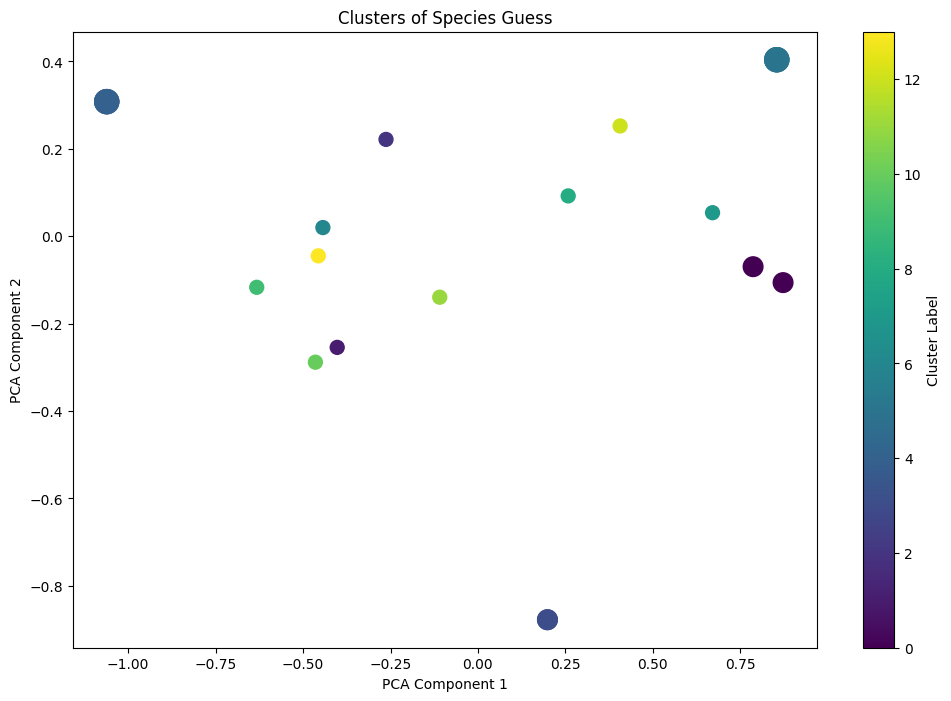

In [9]:
similarity_matrix = compute_fuzzy_similarity_matrix(texts)

# Convert similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix
dbscan = DBSCAN(eps=0.1, min_samples=1, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)
print(clusters)

cluster_counts = np.bincount(clusters + 1)  # Add 1 to handle -1 (noise) cluster
sizes = cluster_counts[clusters + 1] * 100

# Plotting the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(distance_matrix)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap="viridis", s=sizes
)
plt.title("Clusters of Species Guess")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster Label")

plt.show()

taxon.name
episyrphus balteatus      9897
eristalis pertinax        8300
eristalis tenax           6807
helophilus pendulus       6144
myathropa florea          5704
                          ... 
pipizella maculipennis       1
pipizella virens             1
microdon devius              1
melangyna arctica            1
eupeodes americanus          1
Name: count, Length: 200, dtype: int64
(85087,)
top 15: taxon.name
episyrphus balteatus      9897
eristalis pertinax        8300
eristalis tenax           6807
helophilus pendulus       6144
myathropa florea          5704
volucella zonaria         4594
volucella pellucens       3435
merodon equestris         2509
syritta pipiens           2299
eupeodes corollae         2163
melanostoma scalare       2049
sphaerophoria scripta     1904
platycheirus albimanus    1765
volucella inanis          1576
eristalis arbustorum      1561
Name: count, dtype: int64


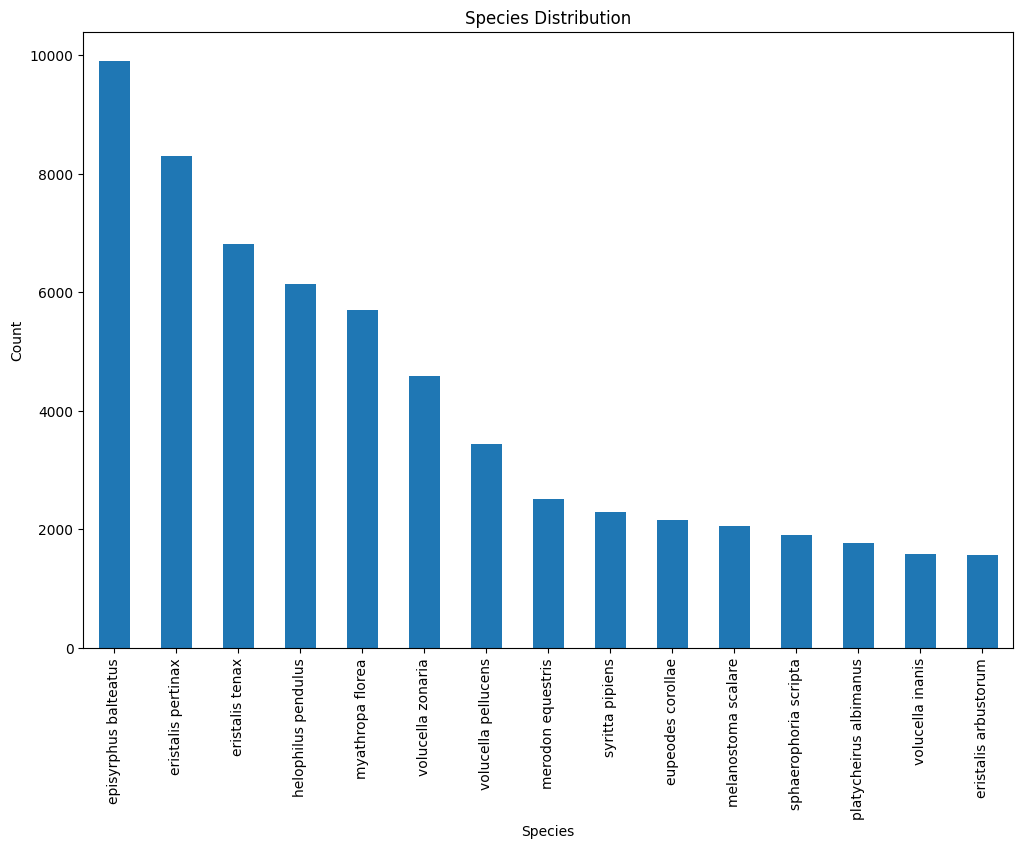

In [10]:
# Labels
species = df[df["taxon.rank"] == "species"]["taxon.name"]
value_counts = species.value_counts()
print(value_counts)
print(species.shape)

top_15_species = value_counts[:15]
print(f"top 15: {top_15_species}")

top_15_species.plot(kind="bar", figsize=(12, 8))
plt.title("Species Distribution")
plt.xlabel("Species")
plt.ylabel("Count")
plt.show()

In [11]:
from sklearn.preprocessing import OneHotEncoder
species_vals = species.unique()

onehot_encoder = OneHotEncoder()
onehot_labels = onehot_encoder.fit_transform(species_vals.reshape(-1, 1))
species_to_onehot = {
    species: onehot_labels[i] for i, species in enumerate(species_vals)
}
print("first encoded label: ", species_to_onehot[species_vals[0]])
print("sum: ", species_to_onehot[species_vals[0]].sum())

df['enocded_lables'] = df['taxon.name'].apply(lambda x: species_to_onehot[x])
df['enocded_lables']

first encoded label:  <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 200)>
  Coords	Values
  (0, 175)	1.0
sum:  1.0


0        <Compressed Sparse Row sparse matrix of dtype ...
1        <Compressed Sparse Row sparse matrix of dtype ...
2        <Compressed Sparse Row sparse matrix of dtype ...
3        <Compressed Sparse Row sparse matrix of dtype ...
4        <Compressed Sparse Row sparse matrix of dtype ...
                               ...                        
85082    <Compressed Sparse Row sparse matrix of dtype ...
85083    <Compressed Sparse Row sparse matrix of dtype ...
85084    <Compressed Sparse Row sparse matrix of dtype ...
85085    <Compressed Sparse Row sparse matrix of dtype ...
85086    <Compressed Sparse Row sparse matrix of dtype ...
Name: enocded_lables, Length: 85087, dtype: object

In [12]:
import torch.onnx
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, num_classes: int):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        # x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
model = CNN(num_classes=species_vals.shape[0])
sample_input = torch.randn(
    2, 3, 128, 128
)  
torch.onnx.export(model, sample_input, "cnn_model.onnx")
# Load the onnx into netron to visualize the model